# AI vs Human Text Classification

## Library and Requirement

In [8]:
import zipfile

import pandas as pd
import os
import numpy as np
import re
import string

import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from keras.initializers import Constant

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [9]:
!pip install contractions

In [10]:
import contractions

In [11]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

In [13]:
# zip_ref = zipfile.ZipFile("/content/glove.6B.zip", 'r')
# zip_ref.extractall("/content/drive/MyDrive/Dataset/Alta Text AI vs Human/")
# zip_ref.close()

## Dataset

### Access Google Drive

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# Process the validation sample output to csv

# import json
# def read_json(file_path):
#     with open(file_path, 'r') as file:
#         data = [json.loads(line) for line in file]
#     return data

# base_dir = '/content/drive/MyDrive/Dataset/Alta Text AI vs Human'
# data_label_val = read_json(base_dir+'/validation_sample_output.json')

# data_label_val = pd.DataFrame(data_label_val)

# data_label_val.to_csv(os.path.join(base_dir, 'validation_sample_output.csv'))

### Check Dataset

In [16]:
base_dir = '/content/drive/MyDrive/Dataset/Alta Text AI vs Human'

df_train = pd.read_csv(base_dir+'/train_preprocess.csv')
df_train = df_train[["text_preprocessing", "label"]]

df_val = pd.read_csv(base_dir+'/val_preprocess.csv')
df_label_val = pd.read_csv(base_dir+'/validation_sample_output.csv')
df_label_val = df_label_val['label']
df_val["label"] = df_label_val
df_val = df_val[["text_preprocessing","label"]]

df_test = pd.read_csv(base_dir+'/test_preprocess.csv')
df_test = df_test[["text_preprocessing"]]

### Data Train

Display sample data train

In [17]:
df_train.head()

,text_preprocessing,label
0,have you ever heard of the crusade ? a time in...,1
1,"the professor , who likely have nearly a decad...",1
2,"emma walker doe a good job of defending foe , ...",1
3,"genius ' lawyer , stanley tardy , urged the go...",1
4,the circuit court of appeal of new jersey had ...,0


Shape of data train based on label

In [18]:
df_train['label'].value_counts()

label
1    9000
0    9000
Name: count, dtype: int64

<Axes: xlabel='label'>

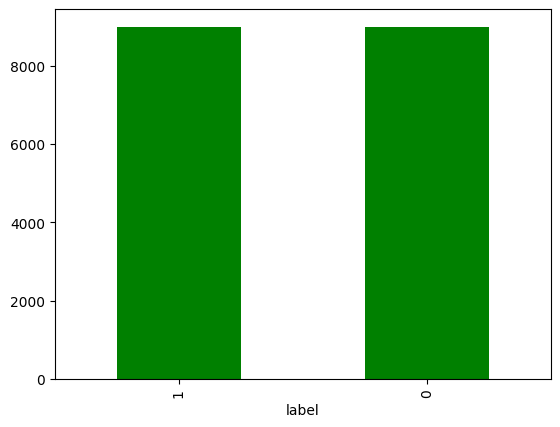

In [19]:
df_train['label'].value_counts().plot(kind='bar', color='green')

### Data Validation

Display sample data validation

In [20]:
df_val.head()

,text_preprocessing,label
0,"so , how to explain this flowering of violin c...",1
1,`` the bill will not authorize a public utilit...,0
2,"[ 2 ] act of april 6 , 1940 , c. 461 , § 15 , ...",0
3,you are nobody til somebody love you - dean ma...,0
4,"`` believe me , when a pole or hungarian come ...",1


Shape of data validation

In [21]:
df_val['label'].value_counts()

label
0    1047
1     953
Name: count, dtype: int64

<Axes: xlabel='label'>

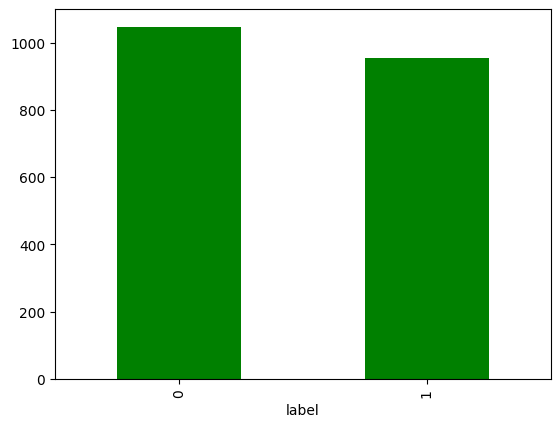

In [22]:
df_val_label = pd.read_csv(base_dir+'/validation_sample_output.csv')
df_val_label['label'].value_counts().plot(kind='bar', color='green')

### Data Test

Display sample data test

In [23]:
df_test.head()

,text_preprocessing
0,investigator are now hamstring by the inabilit...
1,"[ 10 ] indeed , the district court found that ..."
2,`` the second object of this legislation is to...
3,"it is in vain , in a case of this nature , tha..."
4,* 4 mr. justice wayne delivered the opinion of...


Shape of data test

In [24]:
# data_test['label'].value_counts()

df_test.shape

(2000, 1)

In [25]:
# data_test['label'].value_counts().plot(kind='bar', color='green')

## Preprocessing

### Prepare Data

Change all data to list

In [26]:
def dataframe_list(df):
  data = []
  data_len = df.shape[0]
  i = 0

  while (i < data_len):
    data.append(df.loc[i])
    i = i + 1

  return data

In [27]:
data_train_list = dataframe_list(df_train['text_preprocessing'])
data_val_list = dataframe_list(df_val['text_preprocessing'])
data_test_list = dataframe_list(df_test['text_preprocessing'])

print("Sample data: ",data_train_list[0])
print("Jumlah data: ",len(data_train_list))

Sample data:  have you ever heard of the crusade ? a time in which christian went on a 200 year damage throughout europe and on their path to israel in which they slaughtered innocent people in the name of your god ?
Jumlah data:  18000


### Case Folding

Simple preprocessing like lowercase, remove symbol, etc

In [28]:
def case_fold(data_list):
  data = []

  for d in data_list:
  #CASE FOLDING
    # Remove Unicode
    tmp = re.sub(r'[^\x00-\x7F]+', ' ', d)
    # Remove Mentions
    tmp = re.sub(r'@\w+', '', tmp)
    # Remove punctuations
    tmp = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', tmp)
    # Lowercase the numbers
    tmp = re.sub(r'[0-9]', '', tmp)
    # Remove the doubled space
    tmp = re.sub(r'\s{2,}', ' ', tmp)

    # Lowercase the document
    tmp = tmp.lower()
    data.append(tmp)

  return data

In [29]:
data_train_casefold = case_fold(data_train_list)
data_val_casefold = case_fold(data_val_list)
data_test_casefold = case_fold(data_test_list)

In [30]:
print(data_train_casefold[0])
print(len(data_train_casefold[0]))

have you ever heard of the crusade a time in which christian went on a year damage throughout europe and on their path to israel in which they slaughtered innocent people in the name of your god 
195


### Text Correction

In [31]:
def text_correction(data_list):
  data = []

  for i in data_list:
    tmp = contractions.fix(i)
    tmp = TextBlob(tmp).correct()
    data.append(tmp)

  return data

In [32]:
data_train_correction = case_fold(data_train_casefold)
data_val_correction = case_fold(data_val_casefold)
data_test_correction = case_fold(data_test_casefold)

In [33]:
print(data_train_correction[0])
print(len(data_train_correction[0]))

have you ever heard of the crusade a time in which christian went on a year damage throughout europe and on their path to israel in which they slaughtered innocent people in the name of your god 
195


### Tokenizing

Change sentences to small parts (words)

In [34]:
def token(data_list):
  data = []

  for i in data_list:
    data.append(nltk.tokenize.word_tokenize(i))

  return data

In [35]:
data_train_token = token(data_train_correction)
data_val_token = token(data_val_correction)
data_test_token = token(data_test_correction)

print("Sample data: ",data_train_token[0])
print("Jumlah data pertama: ",len(data_train_token[0]))
print("Jumlah data: ",len(data_train_token))

Sample data:  ['have', 'you', 'ever', 'heard', 'of', 'the', 'crusade', 'a', 'time', 'in', 'which', 'christian', 'went', 'on', 'a', 'year', 'damage', 'throughout', 'europe', 'and', 'on', 'their', 'path', 'to', 'israel', 'in', 'which', 'they', 'slaughtered', 'innocent', 'people', 'in', 'the', 'name', 'of', 'your', 'god']
Jumlah data pertama:  37
Jumlah data:  18000


### Stopwords Removal

Deleting words that is uninformative to get focus of the data

In [36]:
def stopwordsremoval(data_token):
  data = []
  tmp = []
  stop_words = set(stopwords.words('english'))

  for i in data_token:
    for j in i:
      if j not in stop_words:
          tmp.append(j)
    data.append(tmp)
    tmp = []

  return data

In [37]:
data_train_stopwords = stopwordsremoval(data_train_token)
data_val_stopwords = stopwordsremoval(data_val_token)
data_test_stopwords = stopwordsremoval(data_test_token)

print("Sample data: ",data_train_stopwords[0])
print("Jumlah data pertama: ",len(data_train_stopwords[0]))
print("Jumlah data: ",len(data_train_stopwords))

Sample data:  ['ever', 'heard', 'crusade', 'time', 'christian', 'went', 'year', 'damage', 'throughout', 'europe', 'path', 'israel', 'slaughtered', 'innocent', 'people', 'name', 'god']
Jumlah data pertama:  17
Jumlah data:  18000


### Stemming

Reduce or change the words to the root form

In [38]:
def stem(data_stopwords):
  data = []
  tmp = []
  snow_stemmer = SnowballStemmer(language='english')

  for i in data_stopwords:
    for j in i:
      tmp.append(snow_stemmer.stem(j))
    data.append(tmp)
    tmp = []

  return data

In [39]:
data_train_stem = stem(data_train_stopwords)
data_val_stem = stem(data_val_stopwords)
data_test_stem  = stem(data_test_stopwords)

print("Sample data: ",data_train_stem[0])
print("Jumlah data pertama: ",len(data_train_stem[0]))
print("Jumlah data: ",len(data_train_stem))

Sample data:  ['ever', 'heard', 'crusad', 'time', 'christian', 'went', 'year', 'damag', 'throughout', 'europ', 'path', 'israel', 'slaughter', 'innoc', 'peopl', 'name', 'god']
Jumlah data pertama:  17
Jumlah data:  18000


### Lemmatization

Reduce or change the words to the root form

In [40]:
def lemma(data_stopwords):
  data = []
  tmp = []
  lemma = WordNetLemmatizer()

  for i in data_stopwords:
    for j in i:
      tmp.append(lemma.lemmatize(j))
    data.append(tmp)
    tmp = []

  return data

In [41]:
data_train_lemma = lemma(data_train_stopwords)
data_val_lemma = lemma(data_val_stopwords)
data_test_lemma  = lemma(data_test_stopwords)

print("Sample data: ",data_train_lemma[0])
print("Jumlah data pertama: ",len(data_train_lemma[0]))
print("Jumlah data: ",len(data_train_lemma))

Sample data:  ['ever', 'heard', 'crusade', 'time', 'christian', 'went', 'year', 'damage', 'throughout', 'europe', 'path', 'israel', 'slaughtered', 'innocent', 'people', 'name', 'god']
Jumlah data pertama:  17
Jumlah data:  18000


### Final Preprocessing

Combine the final data with the label

In [42]:
def list_string(data_stem, separator=' '):
    data = []
    tmp = []

    for i in data_stem:
      data.append(separator.join(i))

    return data

def list_df(data_final, data_start):

  for i in data_final:
    df = pd.DataFrame(data_final, columns=['Text'])
    df['Label'] = data_start['label']

  return df

def list_df_test(data_final, data_start):

  for i in data_final:
    df = pd.DataFrame(data_final, columns=['Text'])
    # df['Label'] = data_start['label']

  return df

In [43]:
data_train_final = list_string(data_train_lemma)
data_val_final = list_string(data_val_lemma)
data_test_final = list_string(data_test_lemma)

print("Sample data: ",data_train_final[0])
print("Jumlah data: ",len(data_train_final))

Sample data:  ever heard crusade time christian went year damage throughout europe path israel slaughtered innocent people name god
Jumlah data:  18000


In [44]:
df_train_final = list_df(data_train_final, df_train)
df_val_final = list_df(data_val_final, df_val)
df_test_final = list_df_test(data_test_final, df_test)

In [45]:
df_train_final.head()

,Text,Label
0,ever heard crusade time christian went year da...,1
1,professor likely nearly decade education also ...,1
2,emma walker doe good job defending foe better ...,1
3,genius lawyer stanley tardy urged government s...,1
4,circuit court appeal new jersey jurisdiction c...,0


In [46]:
df_val_final.head()

,Text,Label
0,explain flowering violin concert decade,1
1,bill authorize public utility deny exercise ri...,0
2,act april c state act may c state,0
3,nobody til somebody love dean martin,0
4,believe pole hungarian come slovak nearby fren...,1


In [47]:
df_test_final

,Text
0,investigator hamstring inability compel witnes...
1,indeed district court found petitioner able us...
2,second object legislation protect employee rai...
3,vain case nature court look intention legislat...
4,mr justice wayne delivered opinion court
...,...
1995,namely due finish cutting second tunnel later ...
1996,opinion case stated property suit assigned ass...
1997,justice department statement went acknowledgin...
1998,higher ground reach top map reward star world ...


Save final data to csv

In [48]:
# data_final = pd.DataFrame(data_final, columns=['Text'])


In [49]:
# df_final_labeled.head()

## Word Cloud

Graph of most frequent data and wordcloud visualization

In [ ]:
def graph_freq(df_final):
  cv = CountVectorizer()
  data = df_final["Text"]
  words = cv.fit_transform(data)
  sum_words = words.sum(axis=0)

  words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
  frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

  frequency.head(50).plot(x='word', y='freq', kind='bar', figsize=(15, 7), cmap = 'magma')
  plt.title("Most Frequently Occuring Words - Top 30")

def wordcloud(df_final):
  result_wordcloud = WordCloud(background_color="white", width=3000, height=2000, max_words=1000).generate(' '.join(df_final["Text"]))

  plt.imshow(result_wordcloud)
  plt.axis("off")
  plt.show()

### Data Train

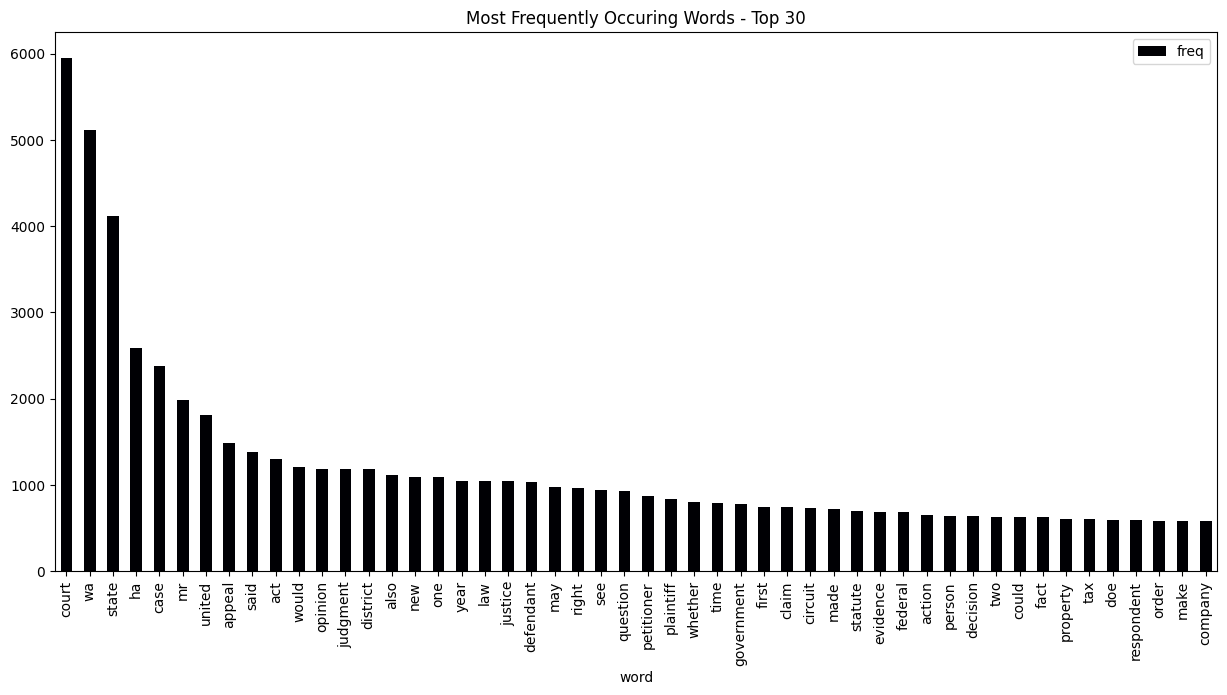

In [ ]:
graph_freq(df_train_final)

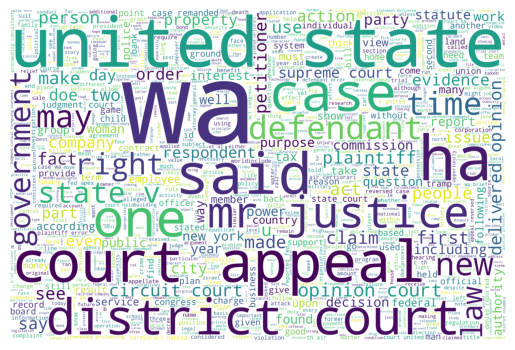

In [ ]:
wordcloud(df_train_final)

visualization with data label = 0

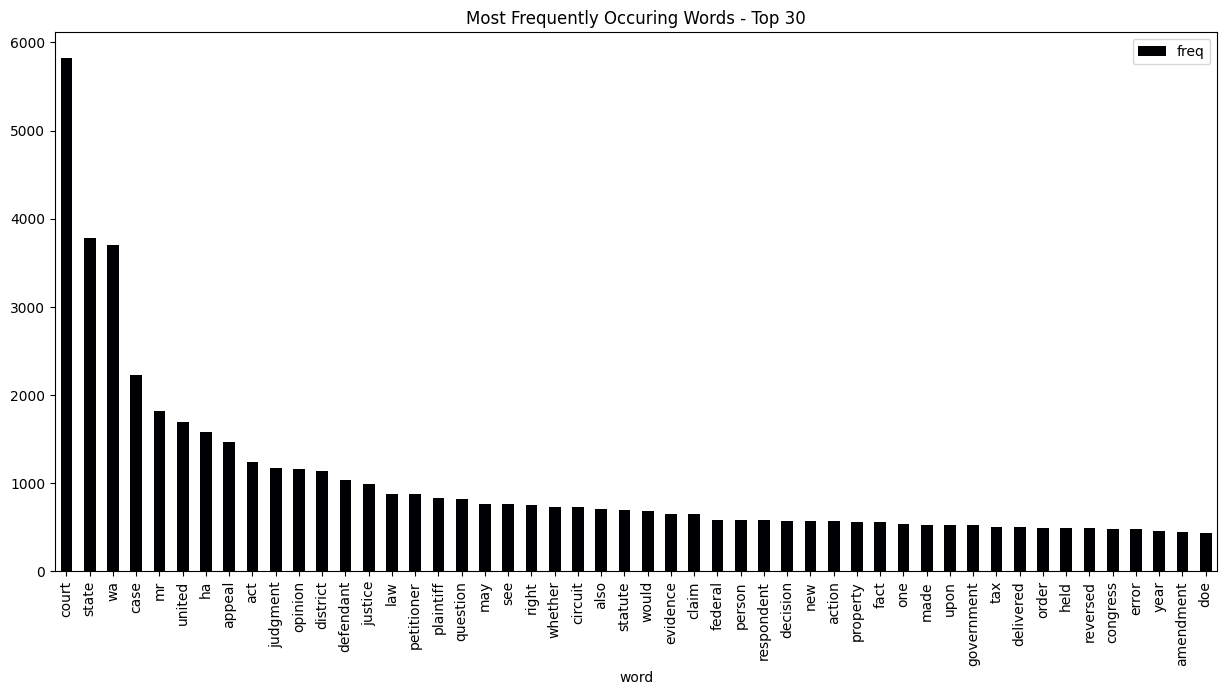

In [ ]:
graph_freq(df_train_final[df_train_final['Label'] == 0])

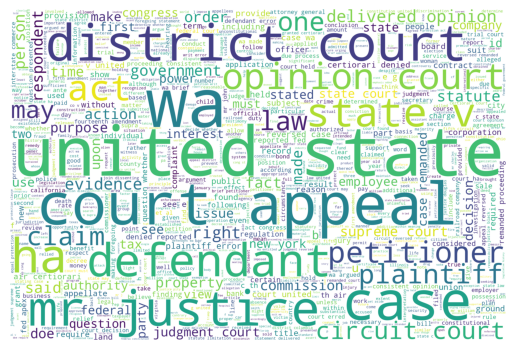

In [ ]:
wordcloud(df_train_final[df_train_final['Label'] == 0])

visualization with data label = 1

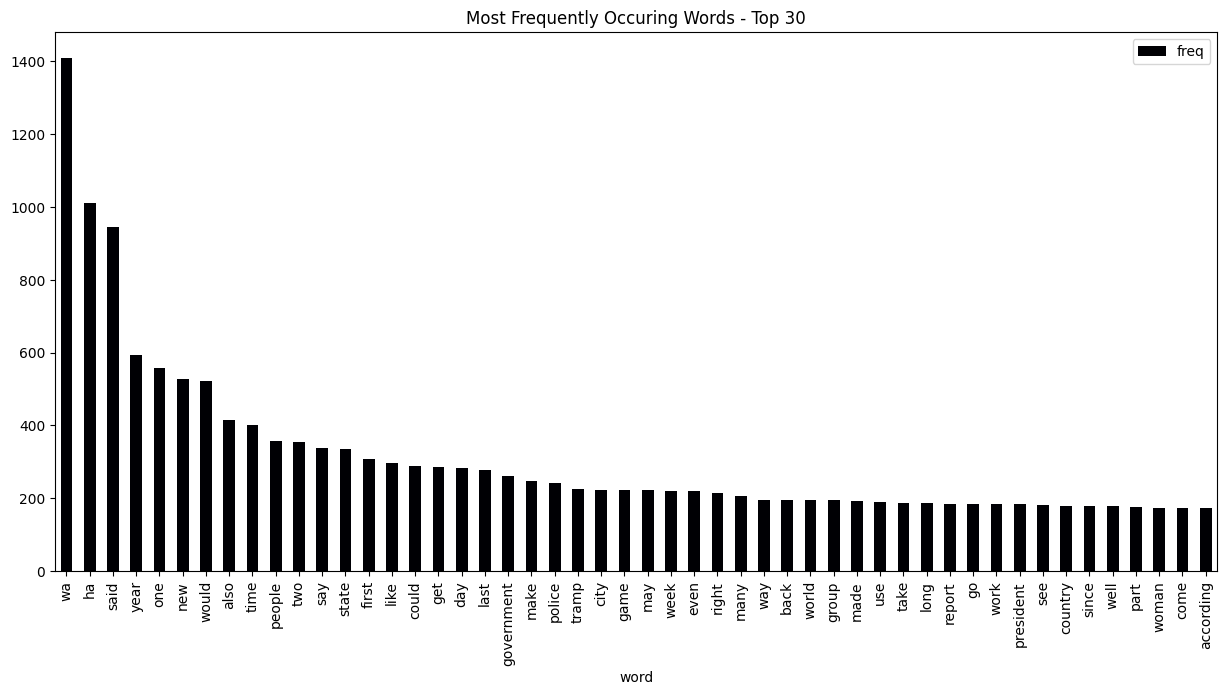

In [ ]:
graph_freq(df_train_final[df_train_final['Label'] == 1])

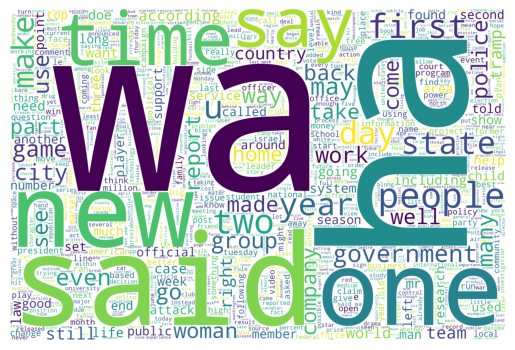

In [ ]:
wordcloud(df_train_final[df_train_final['Label'] == 1])

### Data Validation

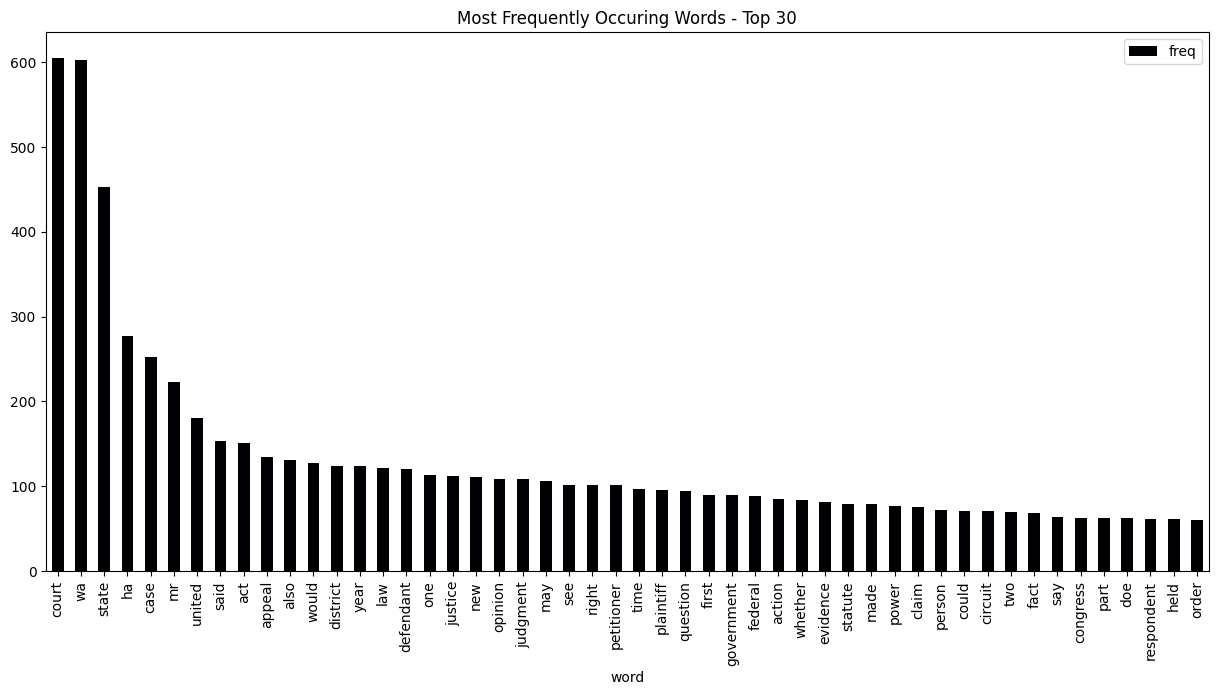

In [ ]:
graph_freq(df_val_final)

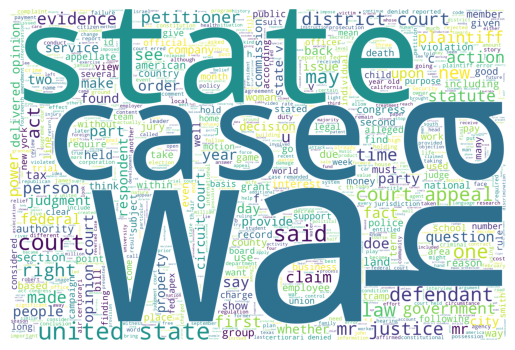

In [ ]:
wordcloud(df_val_final)

### Data Test

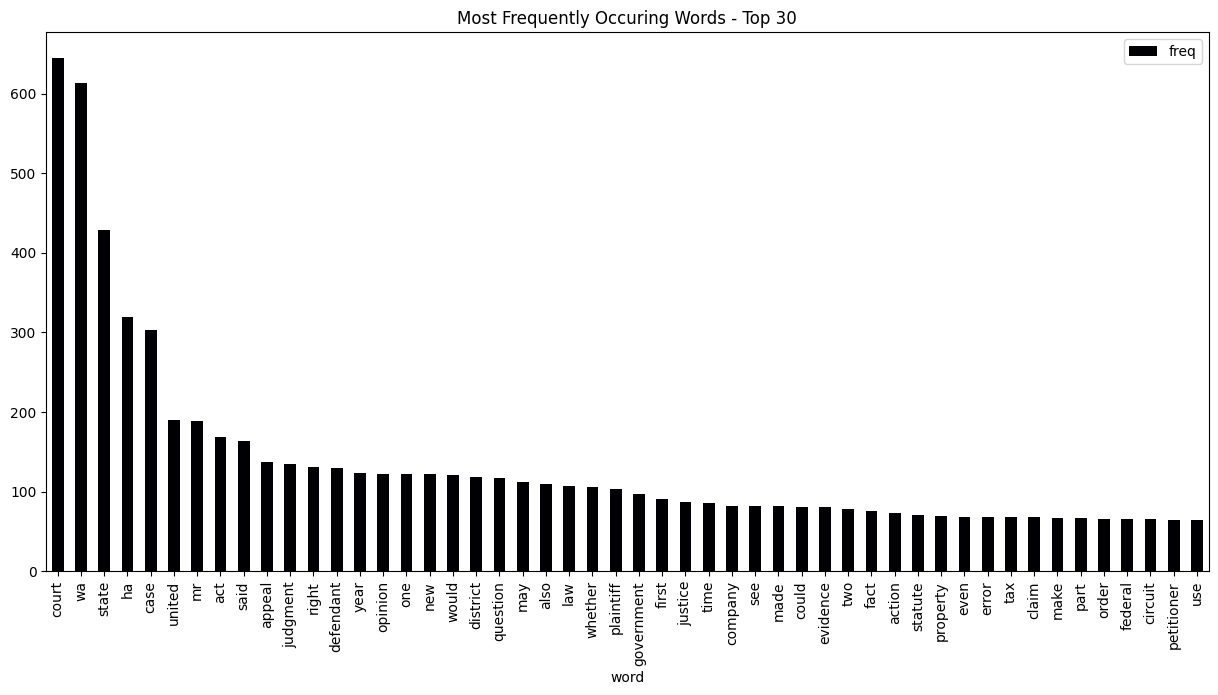

In [ ]:
graph_freq(df_test_final)

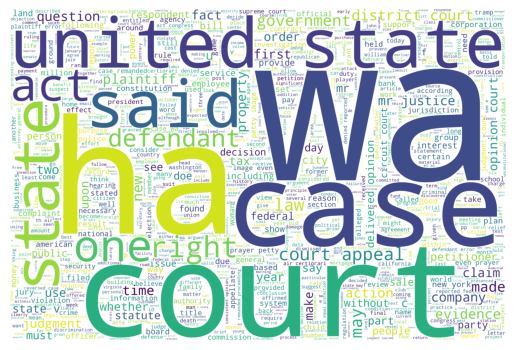

In [ ]:
wordcloud(df_test_final)

## Deep Learning

### Library Extensions

In [50]:
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.models import Sequential
from keras.initializers import Constant
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional, BatchNormalization, GlobalMaxPool1D
from tensorflow.keras.models import load_model

### Split Data

In [51]:
x_train = df_train_final['Text']
y_train = df_train_final['Label']

In [52]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.05, random_state = 123)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(17100,)
(900,)
(17100,)
(900,)


### Tokenization

Defining pre-processing parameters

In [53]:
cv = CountVectorizer()
x = cv.fit_transform(x_train)

# vocab_size = x.shape[1]
vocab_size = 10000
oov_tok = '<OOV>'
trunc_type = 'post'
padding_type = 'post'
embedding_dim = 50

In [54]:
tokenizer = Tokenizer(num_words = vocab_size,
                      char_level = False,
                      oov_token = '<OOV>')
tokenizer.fit_on_texts(x_train)

Get the word_index

In [55]:
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

18042

### Sequence and Padding

In [56]:
max_length = df_train_final['Text'].apply(lambda x: len(x.split())).max()

print(max_length)

109


Data Train

In [57]:
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_length,
                                padding = padding_type,
                                truncating = trunc_type)

Data Validation

In [58]:
val_sequences = tokenizer.texts_to_sequences(x_val)
val_padded = pad_sequences(val_sequences,
                               maxlen = max_length,
                               padding = padding_type,
                               truncating = trunc_type)

Check Shape

In [59]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of val tensor: ', val_padded.shape)

Shape of training tensor:  (17100, 109)
Shape of val tensor:  (900, 109)


## BoW - BiLSTM

### Bi-LSTM

In [60]:
# Define parameter
n_lstm1 = 32
n_lstm2 = 64
n_lstm3 = 128
drop_lstm = 0.05

model2 = Sequential()
model2.add(Embedding(vocab_size,
                     embedding_dim))

model2.add(Bidirectional(LSTM(n_lstm1, return_sequences = True)))
model2.add(BatchNormalization())
model2.add(Dropout(drop_lstm))

model2.add(Bidirectional(LSTM(n_lstm2, return_sequences = True)))
model2.add(BatchNormalization())
model2.add(Dropout(drop_lstm))

model2.add(Bidirectional(LSTM(n_lstm3, return_sequences = False)))
model2.add(BatchNormalization())
model2.add(Dropout(drop_lstm))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [61]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          500000    
                                                                 
 bidirectional (Bidirection  (None, None, 64)          21248     
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, None, 64)          256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 128)         66048     
 onal)                                                           
                                                        

In [62]:
checkpoint_filepath = '/content/drive/MyDrive/Dataset/Alta Text AI vs Human/Bi-LSTM_BoW.keras'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [63]:
model2.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics=['accuracy'])

In [64]:
num_epochs = 50
# early_stop = EarlyStopping(monitor = 'val_loss',
#                            patience = 2)
history = model2.fit(training_padded,
                     y_train,
                     batch_size = 32,
                     epochs = num_epochs,
                     validation_data = (val_padded, y_val),
                     callbacks=[model_checkpoint_callback],
                     verbose = 1)

Epoch 1/50
535/535 [==============================] - ETA: 0s - loss: 0.2601 - accuracy: 0.8971
Epoch 1: val_accuracy improved from -inf to 0.88667, saving model to /content/drive/MyDrive/Dataset/Alta Text AI vs Human/Bi-LSTM_BoW.keras
535/535 [==============================] - 73s 108ms/step - loss: 0.2601 - accuracy: 0.8971 - val_loss: 0.3320 - val_accuracy: 0.8867
Epoch 2/50
535/535 [==============================] - ETA: 0s - loss: 0.1255 - accuracy: 0.9560
Epoch 2: val_accuracy improved from 0.88667 to 0.93333, saving model to /content/drive/MyDrive/Dataset/Alta Text AI vs Human/Bi-LSTM_BoW.keras
535/535 [==============================] - 25s 46ms/step - loss: 0.1255 - accuracy: 0.9560 - val_loss: 0.2097 - val_accuracy: 0.9333
Epoch 3/50
535/535 [==============================] - ETA: 0s - loss: 0.0593 - accuracy: 0.9799
Epoch 3: val_accuracy did not improve from 0.93333
535/535 [==============================] - 24s 45ms/step - loss: 0.0593 - accuracy: 0.9799 - val_loss: 4.6153 -

In [65]:
model2.evaluate(val_padded, y_val)

29/29 [==============================] - 0s 16ms/step - loss: 0.5293 - accuracy: 0.9411


[0.5293015241622925, 0.9411110877990723]

### Visualization

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

<Figure size 640x480 with 0 Axes>

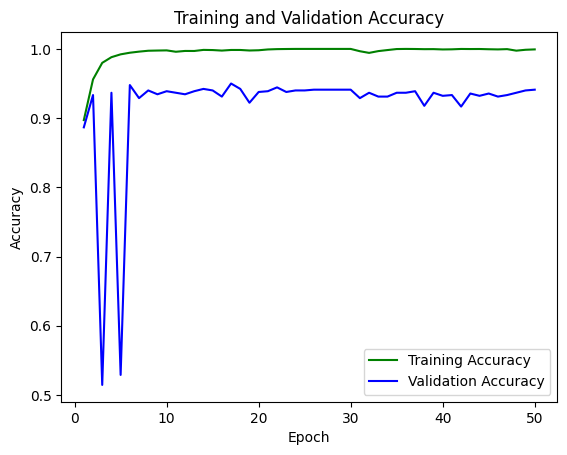

<Figure size 640x480 with 0 Axes>

In [67]:
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

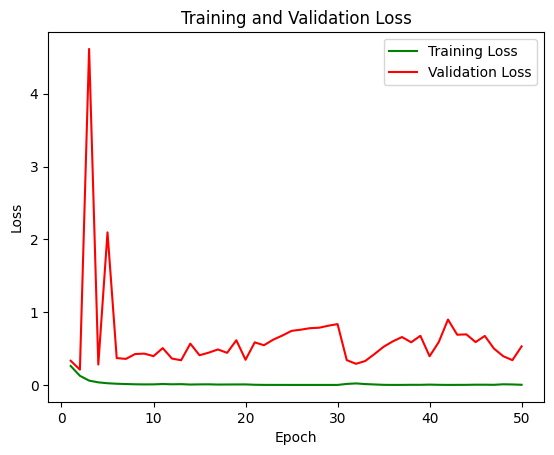

In [68]:
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Save Model

In [69]:
base_dir = '/content/drive/MyDrive/Dataset/Alta Text AI vs Human'

In [70]:
new_model = load_model(base_dir+'/Bi-LSTM_BoW.keras')

In [71]:
def predict_unseen(unseen_data):
  unseen_sequences = tokenizer.texts_to_sequences(unseen_data)
  unseen_padded = pad_sequences(unseen_sequences,
                                  maxlen = max_length,
                                  padding = padding_type,
                                  truncating = trunc_type)

  y_unseen = np.round(new_model.predict(unseen_padded),0)

  return(y_unseen)

y_unseen = predict_unseen(df_test_final["Text"])

63/63 [==============================] - 4s 16ms/step


In [72]:
tmp = []
id = []
count = 0

for i in y_unseen:
  for j in i:
    i = int(j)
    tmp.append(i)

  id.append(count)
  count = count+1


dict_data = {'id':id, 'label':tmp}
df = pd.DataFrame(dict_data)

df.to_csv('Bi_LSTM_BoW_10k.csv', index=False)

https://csvjson.com/csv2json

In [73]:
df.to_json(r"Bi_LSTM_BoW_10k.json", orient="records", lines=True)

## GloVe - BiLSTM

### GloVe Embeddings

In [ ]:
embeddings_index = dict()
f = open('/content/drive/MyDrive/Dataset/Alta Text AI vs Human/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print(len(embeddings_index))

Map each unique word index with its Glove Vector

In [ ]:
num_words = min(vocab_size, len(word_index)) + 1

embedding_matrix = np.zeros((num_words, embedding_dim))
# for word, i in tokenizer.word_index.items():
#   # print(word)
#   # print(i)
#   embedding_vector = embeddings_index.get(word)
#   if embedding_vector is not None:
#       embedding_matrix[i-1] = embedding_vector

for word, i in word_index.items():
    if i > vocab_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

### Bi-LSTM

In [ ]:
# Define parameter
n_lstm1 = 32
n_lstm2 = 64
n_lstm3 = 128
drop_lstm = 0.05

model2 = Sequential()
model2.add(Embedding(num_words,
                     embedding_dim,
                     weights = [embedding_matrix],
                     input_length = max_length,
                     trainable=False
                     ))

model2.add(Bidirectional(LSTM(n_lstm1, return_sequences = True)))
model2.add(BatchNormalization())
model2.add(Dropout(drop_lstm))

model2.add(Bidirectional(LSTM(n_lstm2, return_sequences = True)))
model2.add(BatchNormalization())
model2.add(Dropout(drop_lstm))

model2.add(Bidirectional(LSTM(n_lstm3, return_sequences = True)))
model2.add(BatchNormalization())
model2.add(Dropout(drop_lstm))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 109, 50)           500050    
                                                                 
 bidirectional_43 (Bidirect  (None, 109, 64)           21248     
 ional)                                                          
                                                                 
 batch_normalization_43 (Ba  (None, 109, 64)           256       
 tchNormalization)                                               
                                                                 
 dropout_43 (Dropout)        (None, 109, 64)           0         
                                                                 
 bidirectional_44 (Bidirect  (None, 109, 128)          66048     
 ional)                                                          
                                                     

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/Dataset/Alta Text AI vs Human/Bi-LSTM_Glove.keras'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [ ]:
model2.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics=['accuracy'])

In [ ]:
num_epochs = 50
# early_stop = EarlyStopping(monitor = 'val_loss',
#                            patience = 2)
history = model2.fit(training_padded,
                     y_train,
                     batch_size = 32,
                     epochs = num_epochs,
                     validation_data = (val_padded, y_val),
                     callbacks=[model_checkpoint_callback],
                     verbose = 1)

Epoch 1/50
535/535 [==============================] - ETA: 0s - loss: 0.3304 - accuracy: 0.8938
Epoch 1: val_accuracy improved from -inf to 0.90111, saving model to /content/drive/MyDrive/Dataset/Alta Text AI vs Human/Bi-LSTM_Glove.keras
535/535 [==============================] - 32s 38ms/step - loss: 0.3304 - accuracy: 0.8938 - val_loss: 0.2546 - val_accuracy: 0.9011
Epoch 2/50
534/535 [============================>.] - ETA: 0s - loss: 0.2372 - accuracy: 0.9127
Epoch 2: val_accuracy improved from 0.90111 to 0.91000, saving model to /content/drive/MyDrive/Dataset/Alta Text AI vs Human/Bi-LSTM_Glove.keras
535/535 [==============================] - 17s 32ms/step - loss: 0.2373 - accuracy: 0.9126 - val_loss: 0.2293 - val_accuracy: 0.9100
Epoch 3/50
535/535 [==============================] - ETA: 0s - loss: 0.2051 - accuracy: 0.9225
Epoch 3: val_accuracy did not improve from 0.91000
535/535 [==============================] - 18s 34ms/step - loss: 0.2051 - accuracy: 0.9225 - val_loss: 0.245

In [ ]:
model2.evaluate(val_padded, y_val)

29/29 [==============================] - 0s 16ms/step - loss: 0.3460 - accuracy: 0.9400


[0.3459808826446533, 0.9399999976158142]

### Visualization

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

<Figure size 640x480 with 0 Axes>

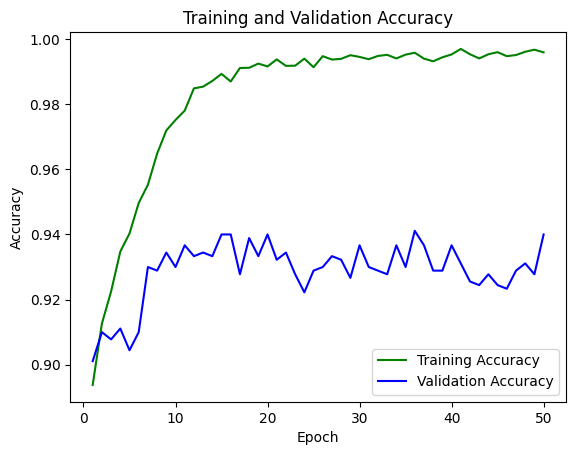

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

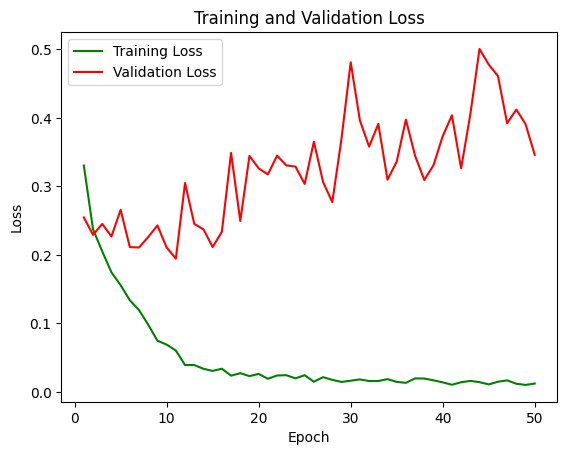

In [ ]:
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Save Model

In [ ]:
base_dir = '/content/drive/MyDrive/Dataset/Alta Text AI vs Human'

In [ ]:
new_model = load_model(base_dir+'/Bi-LSTM_Glove.keras')

In [ ]:
def predict_unseen(unseen_data):
  unseen_sequences = tokenizer.texts_to_sequences(unseen_data)
  unseen_padded = pad_sequences(unseen_sequences,
                                  maxlen = max_length,
                                  padding = padding_type,
                                  truncating = trunc_type)

  y_unseen = np.round(new_model.predict(unseen_padded),0)

  return(y_unseen)

y_unseen = predict_unseen(df_test_final["Text"])

63/63 [==============================] - 1s 15ms/step


In [ ]:
tmp = []
id = []
count = 0

for i in y_unseen:
  for j in i:
    i = int(j)
    tmp.append(i)

  id.append(count)
  count = count+1


dict_data = {'id':id, 'label':tmp}
df = pd.DataFrame(dict_data)

df.to_csv('Bi_LSTM_Glove_10k.csv', index=False)

https://csvjson.com/csv2json

In [ ]:
df.to_json(r"Bi_LSTM_Glove_10k.json", orient="records", lines=True)

## Word2Vec - BiLSTM

### Word2Vec

Embedding Model

In [ ]:
Word2vec_train_data = list(map(lambda x: x.split(), x_train))

word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=embedding_dim,
                #  workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 6873


Embedding Matrix

In [ ]:
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (10001, 50)


### Bi-LSTM

In [ ]:
# Define parameter
n_lstm1 = 32
n_lstm2 = 64
n_lstm3 = 128
drop_lstm = 0.05

model2 = Sequential()
model2.add(Embedding(num_words,
                     embedding_dim,
                     weights = [embedding_matrix],
                     input_length = max_length,
                     trainable=False
                     ))

model2.add(Bidirectional(LSTM(n_lstm1, return_sequences = True)))
model2.add(BatchNormalization())
model2.add(Dropout(drop_lstm))

model2.add(Bidirectional(LSTM(n_lstm2, return_sequences = True)))
model2.add(BatchNormalization())
model2.add(Dropout(drop_lstm))

model2.add(Bidirectional(LSTM(n_lstm3, return_sequences = True)))
model2.add(BatchNormalization())
model2.add(Dropout(drop_lstm))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 109, 50)           500050    
                                                                 
 bidirectional (Bidirection  (None, 109, 64)           21248     
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 109, 64)           256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 109, 64)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 109, 128)          66048     
 onal)                                                           
                                                        

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/Dataset/Alta Text AI vs Human/Bi-LSTM_Word2vec.keras'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [ ]:
model2.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics=['accuracy'])

In [ ]:
num_epochs = 50

history = model2.fit(training_padded,
                     y_train,
                     epochs = num_epochs,
                     validation_data = (val_padded, y_val),
                     callbacks=[model_checkpoint_callback],
                     verbose = 1)

Epoch 1/50
535/535 [==============================] - ETA: 0s - loss: 0.3166 - accuracy: 0.9030
Epoch 1: val_accuracy improved from -inf to 0.90222, saving model to /content/drive/MyDrive/Dataset/Alta Text AI vs Human/Bi-LSTM_Word2vec.keras
535/535 [==============================] - 41s 48ms/step - loss: 0.3166 - accuracy: 0.9030 - val_loss: 0.2465 - val_accuracy: 0.9022
Epoch 2/50
534/535 [============================>.] - ETA: 0s - loss: 0.2379 - accuracy: 0.9137
Epoch 2: val_accuracy improved from 0.90222 to 0.90444, saving model to /content/drive/MyDrive/Dataset/Alta Text AI vs Human/Bi-LSTM_Word2vec.keras
535/535 [==============================] - 18s 33ms/step - loss: 0.2379 - accuracy: 0.9137 - val_loss: 0.2472 - val_accuracy: 0.9044
Epoch 3/50
535/535 [==============================] - ETA: 0s - loss: 0.2308 - accuracy: 0.9165
Epoch 3: val_accuracy did not improve from 0.90444
535/535 [==============================] - 17s 31ms/step - loss: 0.2308 - accuracy: 0.9165 - val_loss:

In [ ]:
model2.evaluate(val_padded, y_val)

29/29 [==============================] - 0s 16ms/step - loss: 0.4675 - accuracy: 0.9156


[0.46745848655700684, 0.9155555367469788]

### Visualization

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

<Figure size 640x480 with 0 Axes>

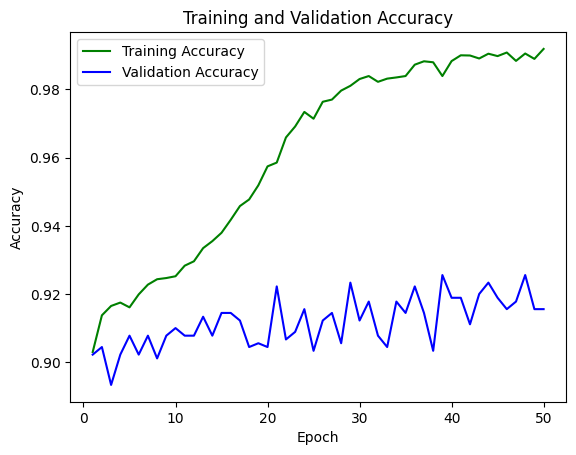

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

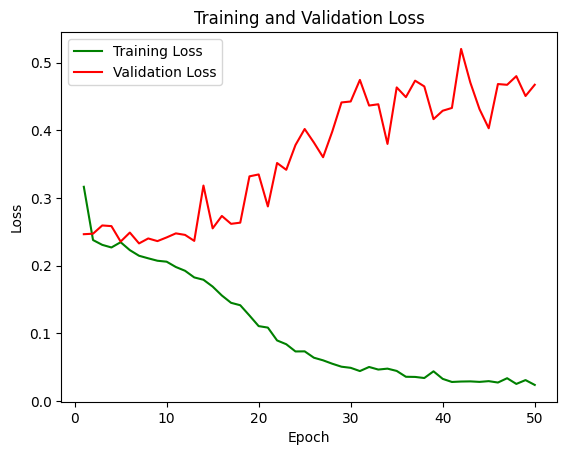

In [ ]:
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Save Model

In [ ]:
base_dir = '/content/drive/MyDrive/Dataset/Alta Text AI vs Human'

In [ ]:
new_model = load_model(base_dir+'/Bi-LSTM_Word2vec.keras')

In [ ]:
def predict_unseen(unseen_data):
  unseen_sequences = tokenizer.texts_to_sequences(unseen_data)
  unseen_padded = pad_sequences(unseen_sequences,
                                  maxlen = max_length,
                                  padding = padding_type,
                                  truncating = trunc_type)

  y_unseen = np.round(new_model.predict(unseen_padded),0)

  return(y_unseen)

y_unseen = predict_unseen(df_test_final["Text"])

63/63 [==============================] - 3s 16ms/step


In [ ]:
tmp = []
id = []
count = 0

for i in y_unseen:
  for j in i:
    i = int(j)
    tmp.append(i)

  id.append(count)
  count = count+1


dict_data = {'id':id, 'label':tmp}
df = pd.DataFrame(dict_data)

df.to_csv('LSTM_Word2vec.csv', index=False)

https://csvjson.com/csv2json

In [ ]:
df.to_json(r"LSTM_Word2vec.json", orient="records", lines=True)